In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.lines as lines
import time
import math

In [35]:
# Configuration variables
a = 2
q = 9
omega = 1.5

ub = 0.01
vb = 0
velocity_boundary = np.array([ub,vb])

nx = 50
ny = 50
L = ny
X, Y = np.meshgrid(np.arange(0,nx), np.arange(0,ny))

# Density weight contribution along the q different directions
w_i = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])

# Velocity components
c_ai = np.array([[0, 1, 0, -1, 0, 1, -1, -1, 1],    # Velocity x-component
              [0, 0, 1, 0, -1, 1, 1, -1, -1]])   # Velocity y-component


In [36]:
def get_rho(f):
    return np.einsum("ijk->jk", f)

def get_u(f, rho):
    return np.einsum('ai,ijk->ajk',c_ai,f)/rho

def stream(f):
    for i in range(9):
        f[i] = np.roll(f[i], shift = c_ai.T[i], axis=[0,1])
    return f

def equilibrium(rho, u):
    feq = []
    for i in range(9):
        cu = np.einsum('a,anm->nm', c_ai.T[i], u)
        uu = np.einsum('anm,anm->nm',u,u)
        term = w_i[i]*rho*(1 + (3 * cu) + (4.5 * (cu**2)) - (1.5 * uu))
        feq.append(term)
    feq = np.stack(feq)
    return feq

def equilibrium_i(rho, u):
    feq = []
    for i in range(9):
        cu = np.einsum('a,an->n', c_ai.T[i], u)
        uu = np.einsum('an,an->n',u,u)
        term = w_i[i]*rho*(1 + (3 * cu) + (4.5 * (cu**2)) - (1.5 * uu))
        feq.append(term)
    feq = np.stack(feq)
    return feq

def collision(f):
    rho = get_rho(f)
    u = get_u(f,rho)
    feq = equilibrium(rho, u)
    
    f = f + (omega * (feq - f))
    return f

def rho_in(rho_in_value=1):
    f = np.einsum("i,j->ij", w_i, np.ones((ny+2))*rho_in_value)
    rho = np.einsum("ij->j", f)
    return rho

def rho_out(rho_out_value=1):
    f = np.einsum("i,j->ij", w_i, np.ones((ny+2))*rho_out_value)
    rho = np.einsum("ij->j", f)
    return rho

def set_pressure_gradient(f, rho_in_value=1, rho_out_value=1):
    rho_p = get_rho(f)
    u_p = get_u(f, rho_p)
    
    feq_star = equilibrium(rho_p,u_p)
    for i in range(9):
        f[:,0,:] = equilibrium_i(rho_in(rho_in_value), u_p[:,-2,:]) + (f[:,-2,:] - feq_star[:,-2,:])
        f[:,-1,:] = equilibrium_i(rho_out(rho_out_value), u_p[:,1,:]) + (f[:,1,:] - feq_star[:,1,:])
        
    return f

#     ax.add_patch(Rectangle((0.5,0.5), nx, ny, fill = False))

In [37]:
# Plots

def plot_density(arr, axis, title=None, boundaries=None):
    
    if title is not None:
        axis.set_title(title)
        
    if boundaries is not None:
        for b in boundaries:
            if isinstance(b, lines.Line2D):
                axis.add_line(b)
            elif isinstance(b, Rectangle):
                axis.add_patch(b)

    axis.imshow(arr.T)
    axis.invert_yaxis()
    
def plot_decay(arr, label_x, label_y, title=None, init_arc=None):
    if init_arc is not None:
        arr = np.insert(arr, 0, init_arc, axis=0)
        
    slen = arr.shape[0]
    subplot_columns = 4
    subplot_rows = math.ceil(slen/subplot_columns)
    fig, axes = plt.subplots(subplot_rows, subplot_columns)
    plt.gcf().set_size_inches(subplot_columns*8,subplot_rows*8)
    plt.setp(axes, xlabel=label_x, ylabel=label_y, ylim=(np.min(arr)*0.999, np.max(arr)*1.001))
    if title:
        plt.suptitle(title, size=20)
    for i in range(slen):
        axis = axes[i//subplot_columns, i%subplot_columns]
        if init_arc is not None and i==0:
            axis.plot(arr[i], color='red')
            axis.set_title("Initial value plot")
        else:
            axis.plot(arr[i])
            axis.set_title(f"Snapshot {i}")
            
def plot_amplitude(arr, label_x, label_y, title=None):
    plt.plot(arr)
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    if title:
        plt.title(title)

In [38]:
# Boundary flow conditions

def top_boundary(f, moving=False, ub=0, vb=0):
    f[4,1:-1,-2] = f[2,1:-1,-1]
    f[7,1:-1,-2] = f[5,2:,-1]
    f[8,1:-1,-2] = f[6,0:-2,-1]
    
    if moving:
        rho_n = (f[0,1:-1,-2] + f[1,1:-1,-2] + f[3,1:-1,-2] + 
                     2*(f[2,1:-1,-1] + f[6,0:-2,-1] + f[5,2:,-1]))/(1+vb)
        horr_factor = 0.5*(f[1,1:-1,-2]-f[3,1:-1,-2])
        ub_factor = 0.5*rho_n*ub
        vb_factor = (1/6)*rho_n*vb
        f[4,1:-1,-2] += (- (2/3)*rho_n*vb)
        f[7,1:-1,-2] += (horr_factor - ub_factor - vb_factor)
        f[8,1:-1,-2] += (- horr_factor + ub_factor - vb_factor)
        
    return f

def bottom_boundary(f, moving=False, ub=0, vb=0):
    f[2,1:-1,1] = f[4,1:-1,0]
    f[5,1:-1,1] = f[7,0:-2,0]
    f[6,1:-1,1] = f[8,2:,0]
    
    if moving:
        raise NotImplementedError()
        
    return f

def left_boundary(f, moving=False, ub=0, vb=0):
    f[1,1,1:-1] = f[3,0,1:-1]
    f[8,1,1:-1] = f[6,0,2:]
    f[5,1,1:-1] = f[7,0,0:-2]
    
    if moving:
        raise NotImplementedError()
        
    return f

def right_boundary(f, moving=False, ub=0, vb=0):
    f[3,-2,1:-1] = f[1,-1,1:-1]
    f[7,-2,1:-1] = f[5,-1,2:]
    f[6,-2,1:-1] = f[8,-1,0:-2]
    
    if moving:
        raise NotImplementedError()
        
    return f
    

In [39]:
def sliding_lid(f_inm):

    ##### Streaming
    
    f_inm = stream(f_inm)
    
    ##### Wall
    
    f_inm = top_boundary(f_inm, moving=True, ub=ub, vb=vb)
#     f_inm = top_boundary(f_inm)
    f_inm = bottom_boundary(f_inm)
    f_inm = left_boundary(f_inm)
    f_inm = right_boundary(f_inm)
    
    ##### Collision
    
    f_inm = collision(f_inm)

    return f_inm

In [40]:
def simulate_sliding_lid(f, iter_length, value_log_period, config_title=None, plot=True):
    slen = math.ceil(iter_length/value_log_period)
    u_periodic = np.empty((slen, ny))
    r_periodic = np.empty((slen, ny))
    u_amplitude = np.empty((slen))
    r_amplitude = np.empty((slen))
    
    if plot:
        subplot_columns = 2
        subplot_rows = math.ceil(slen/subplot_columns)
        fig, axes = plt.subplots(subplot_rows, subplot_columns)
        plt.setp(axes, xticks=range(0,nx+1,5), yticks=range(0,ny+1,5))
        plt.gcf().set_size_inches(subplot_columns*5,subplot_rows*5)
        if config_title:
            plt.suptitle(config_title)

    for i in range(iter_length):
        f = sliding_lid(f)
        if i%value_log_period==0:
            print(i)
            rho = get_rho(f[:,1:-1,1:-1])
            u = get_u(f[:,1:-1,1:-1],rho)
            idx = math.ceil(i/value_log_period)
            u_periodic[idx] = u[0,nx//2,:]
            u_amplitude[idx] = max(u_periodic[idx])
            r_periodic[idx] = rho[nx//2,:]
            r_amplitude[idx] = max(r_periodic[idx])
            
            if plot:
                axis = axes[math.floor(idx/subplot_columns), idx%subplot_columns]
                line_top = lines.Line2D([0.5, 0.5+nx],
                        [0.5, 0.5],
                        color ='black')
                line_bottom = lines.Line2D([0.5, 0.5+nx],
                        [0.5+ny, 0.5+ny],
                        color ='black')
    
                plot_density(rho, axis, f"Step {i}", [line_top, line_bottom])
                axis.streamplot(X, Y, u[0].T, u[1].T,color='white')

    return u_periodic, r_periodic, u_amplitude, r_amplitude, f

0
10
20
30
40
50
60
70
80
90


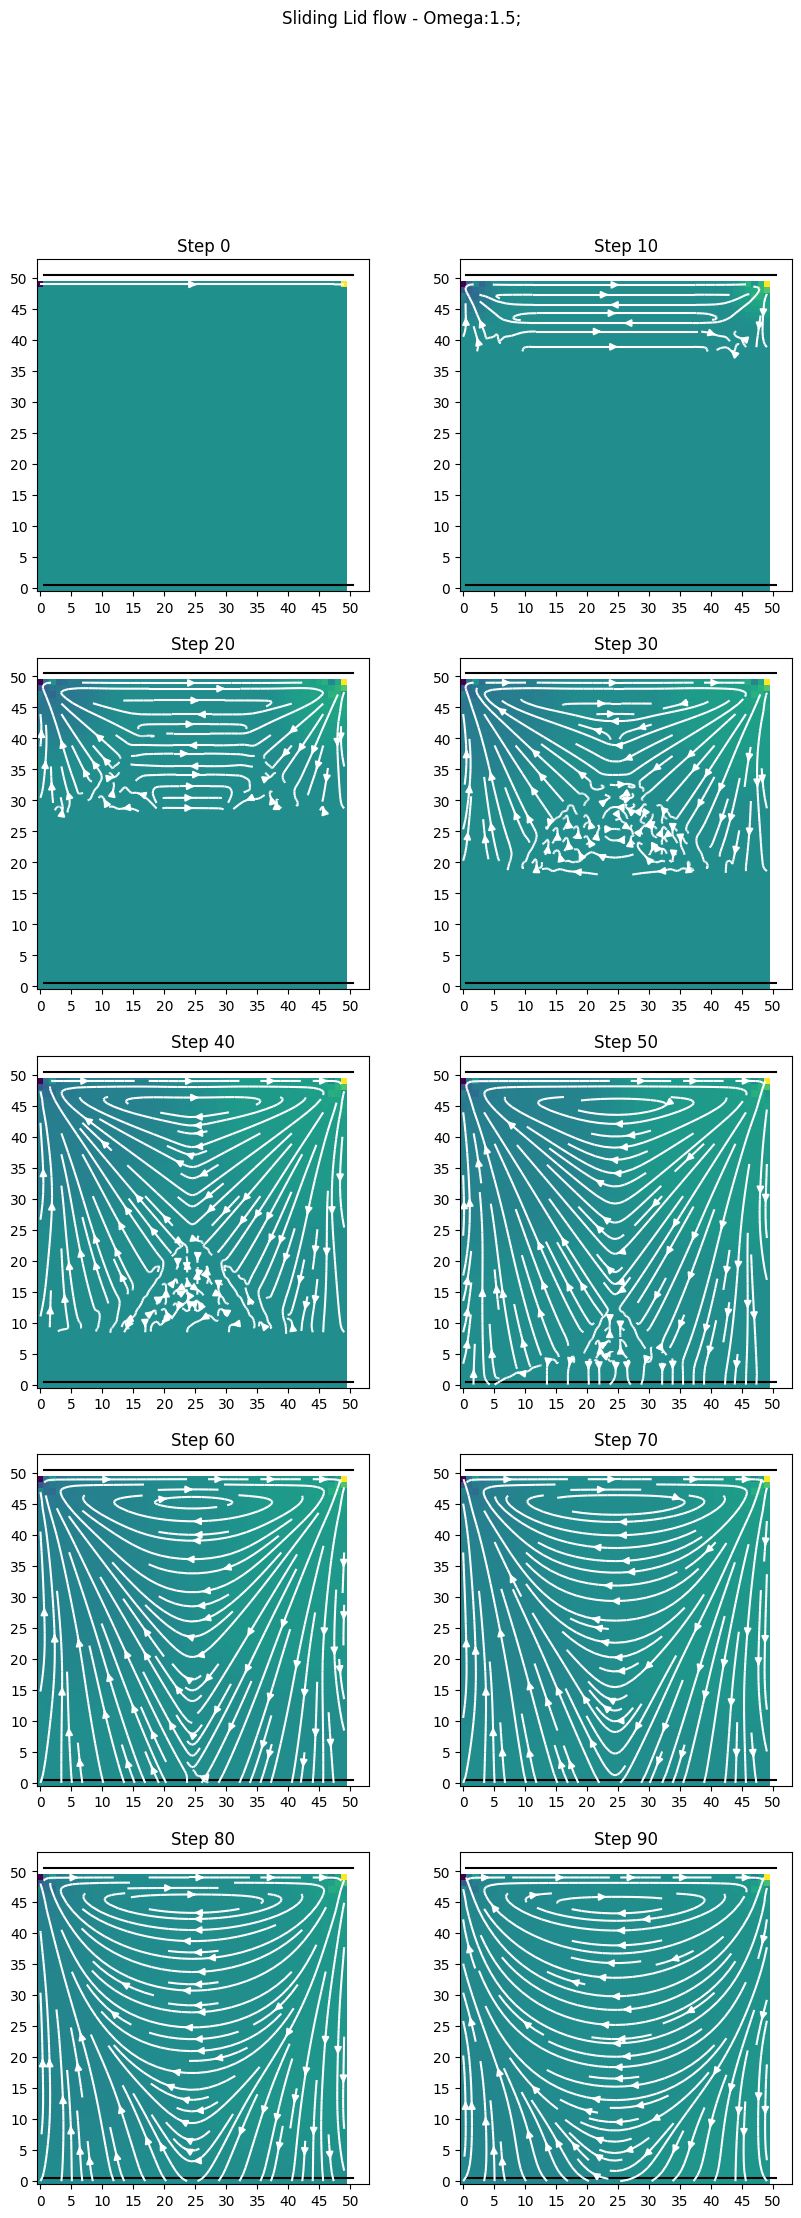

In [42]:
f = np.einsum("i,jk->ijk", w_i, np.ones((nx+2, ny+2)))
#f[:, 8,8] = 0.99*f[:, 8, 8]
config_title = f"Sliding Lid flow - Omega:{omega};"
u_periodic, _, _, _, _ = \
simulate_sliding_lid(f, 100, 10, config_title)
# u_periodic = stream_loop(f, 10000, 1000, plot=True)

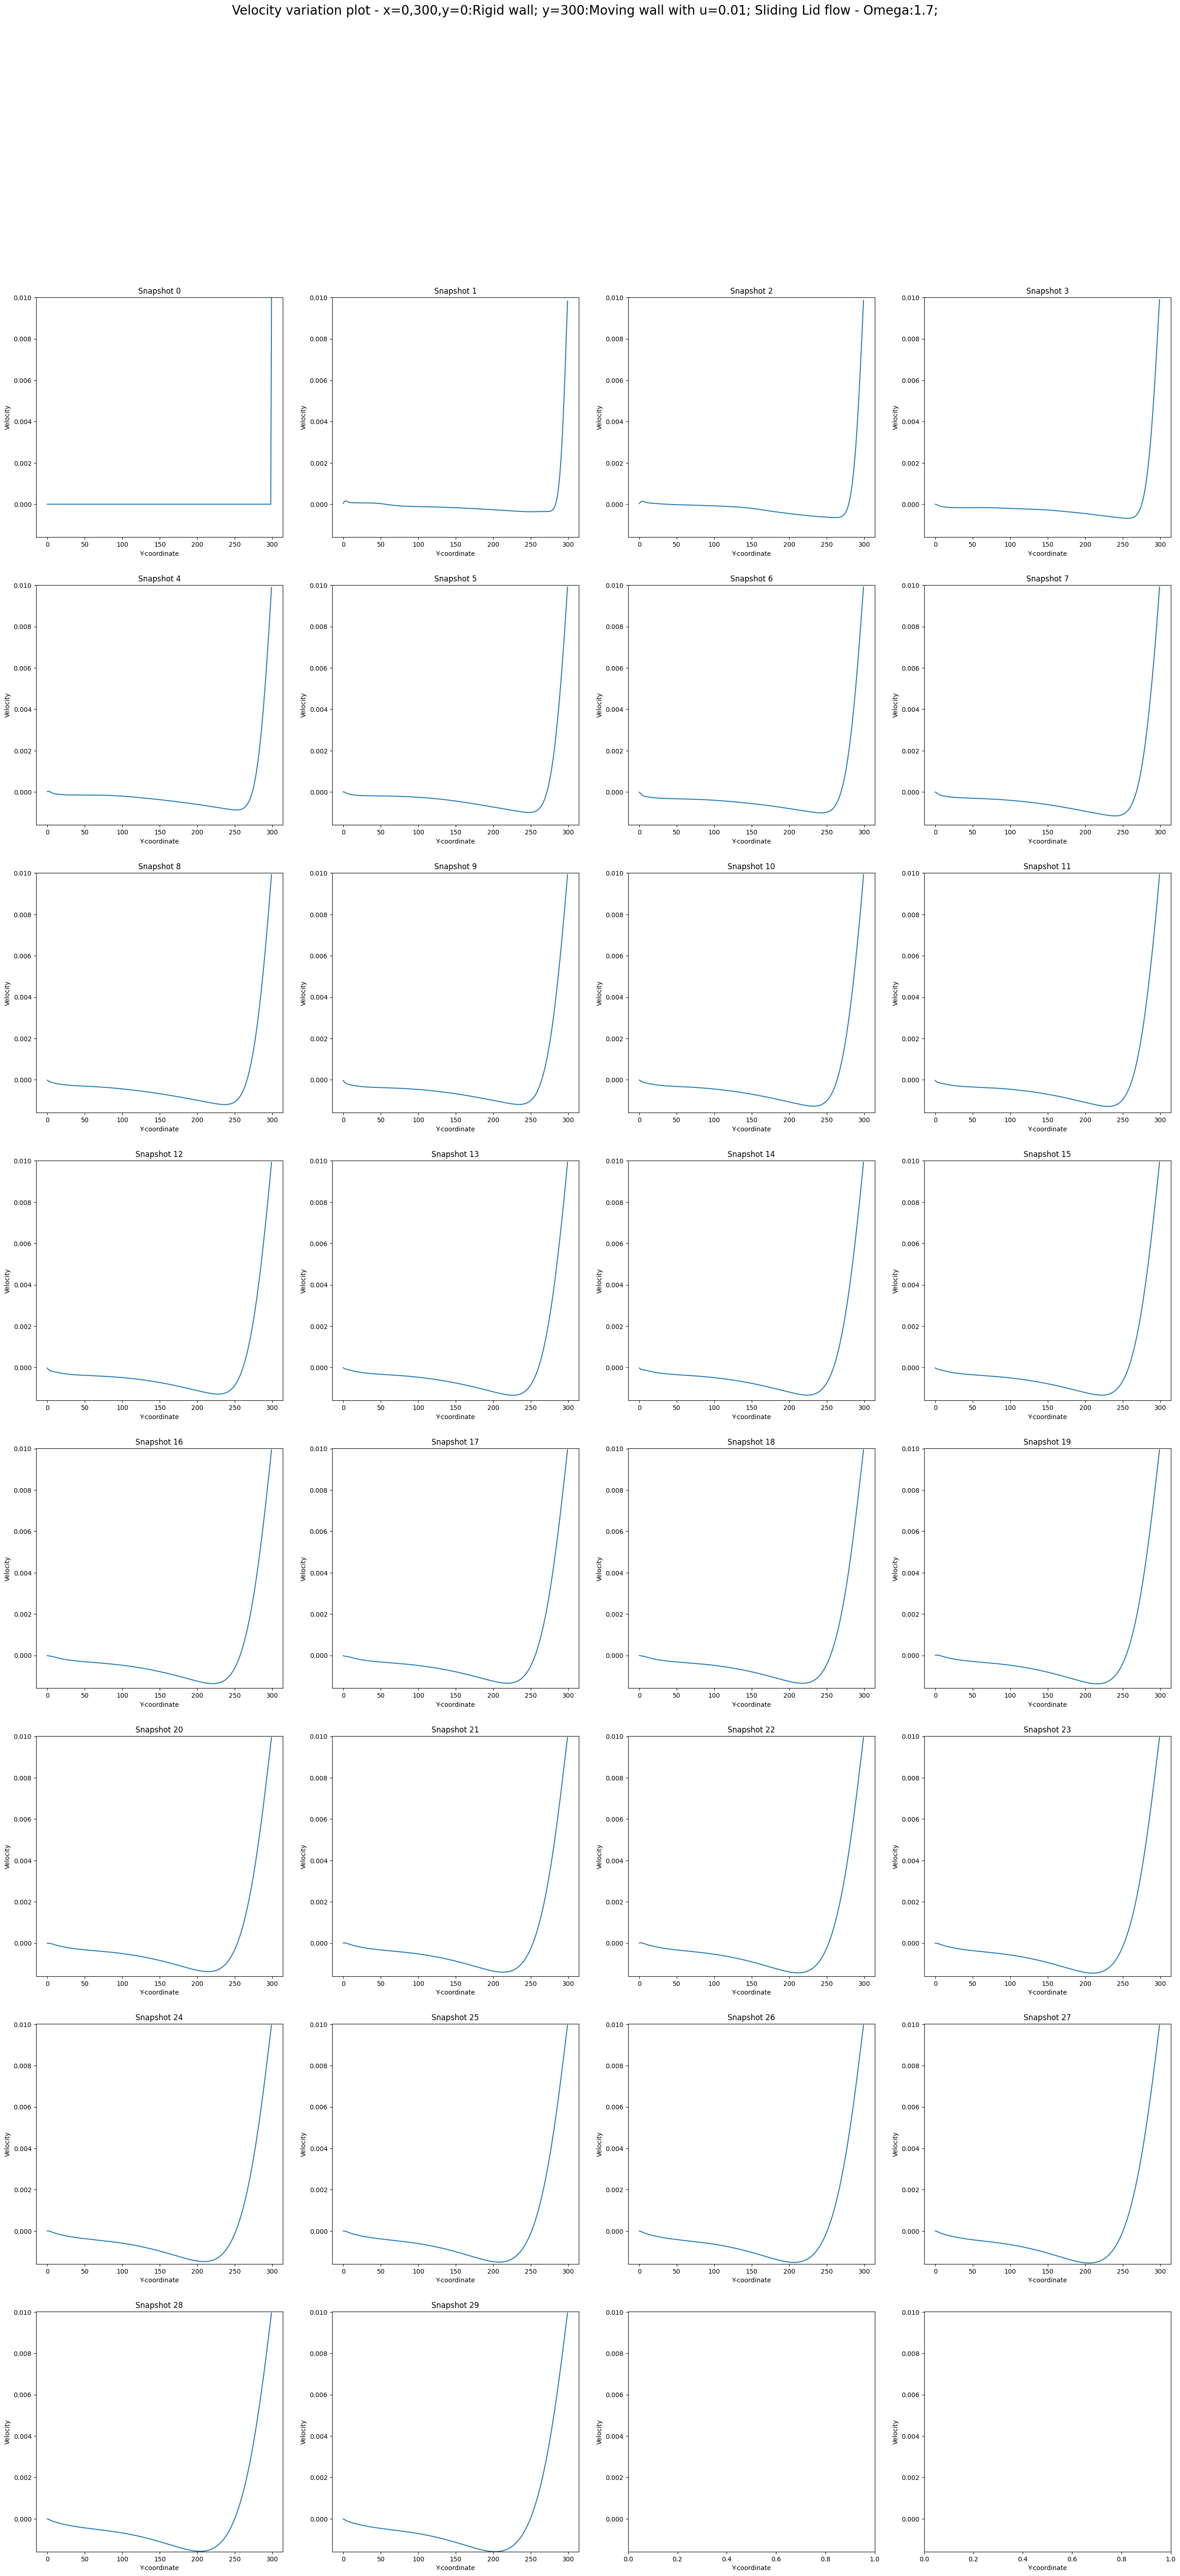

In [21]:
# Wave decay - subplot
plot_decay(u_periodic[:,1:-1], "Y-coordinate", "Velocity", 
           f"Velocity variation plot - x=0,{nx},y=0:Rigid wall; y={ny}:Moving wall with u={ub}; "+config_title)

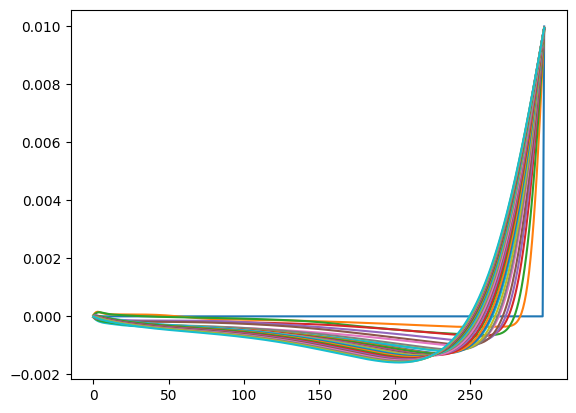

In [22]:
# Plot of velocity

for i in range(u_periodic.shape[0]):
    plt.plot(u_periodic[i][1:-1])
plt.xticks(range(0,nx,50))
plt.show()

In [31]:
# Reynolds number
def get_reynolds_number(L, u, o):
    print(L,u,o)
    nu = (1/3)*((1/o)-0.5)

    return (L*u)/nu

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 ]
300 0.01 1.7
Reynolds number: 102.0
0
300 0.02 1.7
Reynolds number: 204.0
0
300 0.03 1.7
Reynolds number: 306.0
0
300 0.04 1.7
Reynolds number: 408.0
0
300 0.05 1.7
Reynolds number: 510.0
0
300 0.06 1.7
Reynolds number: 612.0
0
300 0.07 1.7
Reynolds number: 714.0
0
300 0.08 1.7
Reynolds number: 816.0
0
300 0.09 1.7
Reynolds number: 918.0
0
300 0.1 1.7
Reynolds number: 1020.0
0


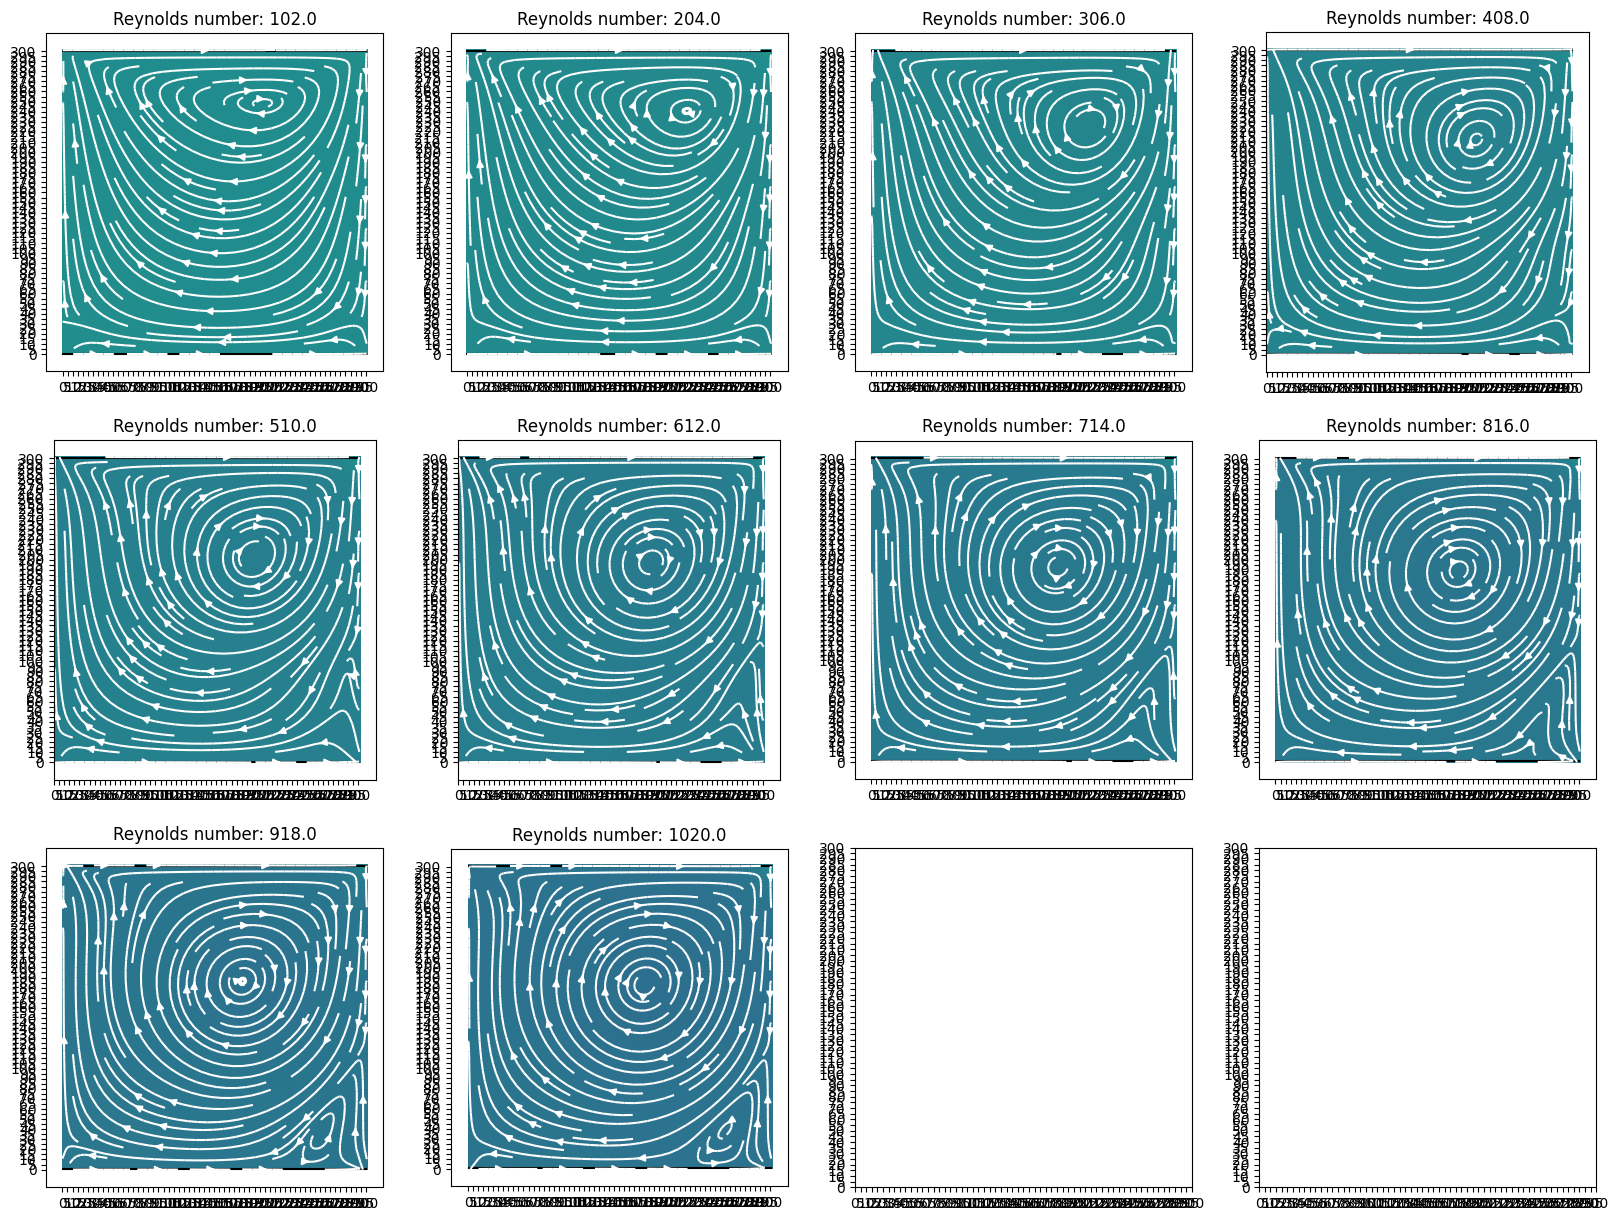

In [33]:
velocity_list = np.round(np.linspace(0.01, 0.1, 10),2)
reynolds_list = np.zeros((len(velocity_list), 2))
print(velocity_list)

subplot_columns = 4
slen = len(velocity_list)
subplot_rows = math.ceil(slen/subplot_columns)
fig, axes = plt.subplots(subplot_rows, subplot_columns)
plt.setp(axes, xticks=range(0,nx+1,5), yticks=range(0,ny+1,5))
plt.gcf().set_size_inches(subplot_columns*5,subplot_rows*5)

for idx, value in enumerate(velocity_list):
    r = np.round(get_reynolds_number(L, value, omega))
    config_title = f"Reynolds number: {r}"
#     "; Grid size: {L}; Velocity: {value}; Omega: {omega}"
    print(config_title)
    
    f = np.einsum("i,jk->ijk", w_i, np.ones((nx+2, ny+2)))
    ub = value
    _, _, _, _, f = simulate_sliding_lid(f, 30000, 30000, config_title, plot=False)
    rho = get_rho(f)
    u = get_u(f,rho)
    
    axis = axes[math.floor(idx/subplot_columns), idx%subplot_columns]
    line_top = lines.Line2D([0.5, 0.5+nx],
            [0.5, 0.5],
            color ='black')
    line_bottom = lines.Line2D([0.5, 0.5+nx],
            [0.5+ny, 0.5+ny],
            color ='black')

    plot_density(rho, axis, config_title, [line_top, line_bottom])
    axis.streamplot(X, Y, u[0].T, u[1].T,color='white')
    
    